## 1. Load Data

#### 1.1 Import images

In [2]:
from scripts.deepgtav.messages import frame2numpy
import numpy as np
import pickle
import gzip
import os
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

filepath = os.path.join(os.getcwd(), 'data')
filename = "dataset_small.pz"
pfile = gzip.open(os.path.join(filepath, filename), mode='rb')

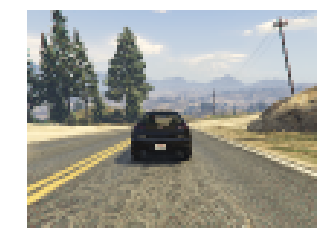

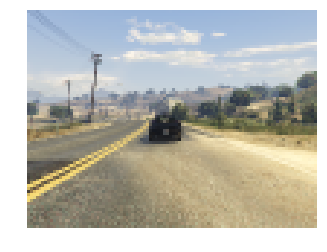

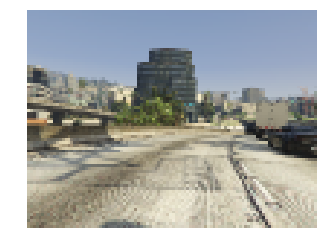

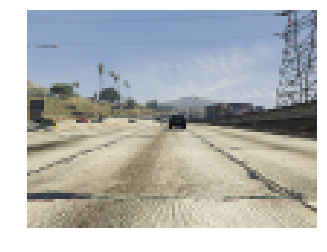

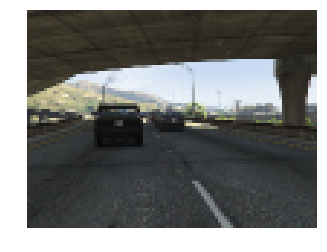

In [2]:
count = 0
no_of_channels = 3

frames_per_weather = 20000
reps_per_weather = 8
frames_per_rep = int(frames_per_weather/reps_per_weather)
image_size = (200,150)

x = []
y = []

while True:
    try:
        
        # Load var from pickle
        var = pickle.load(pfile)
        
        # Skip first n frames
        count += 1
        # if count<3000: continue
            
        # Save image and steering
        image = frame2numpy(var['frame'], image_size)
        image = cv2.resize(image, (100,75))
        x.append(image)
        # y.append([var['steering'], var['throttle'], var['brake']])
        y.append([var['steering']])
        
        # Display image
        if count % 1000 == 0:
            plt.imshow(image[:,:,::-1])
            plt.axis('off')
            plt.show()
        
        if count>5000: break
            
    except EOFError: break

In [3]:
# Convert to numpy
x = np.array(x)
y = np.array(y)
print('Dataset Shape', x.shape, y.shape)

Dataset Shape (5001, 75, 100, 3) (5001, 1)


## 2. Preprocess Data

#### 2.1 Normalize images to [-1,1]

In [4]:
print(np.min(x), np.max(x))
x = (x/255 - 0.5) * 2
np.min(x), np.max(x)

0 255


(-1.0, 1.0)

In [5]:
np.min(y), np.max(y)

(-0.38307901431646607, 0.94253776017364188)

#### 2.4 Split data for train and test

In [6]:
seed = 1
np.random.seed(seed)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=np.random)
print("Train Data | Test Data")
print(("{0:^10} | {1:^10}").format(x_train.shape[0], x_test.shape[0]))

Train Data | Test Data
   4000    |    1001   


## 3. Build Model

#### 3.1 Import Keras and use NCHW mode

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.metrics import mae
from keras.initializers import RandomNormal

from keras import backend
backend.set_image_dim_ordering('tf')

Using TensorFlow backend.


#### 3.2 Create reusable functions

In [8]:
c = x.shape[3]
h = x.shape[1]
w = x.shape[2]
no_of_classes = y.shape[1]
print(x.shape, y.shape)

def evaluate_model(model):
    print("\n\n")
    scores = model.evaluate(x_test, y_test)
    print("Accuracy: ", scores[1]*100, "%")
    return scores

(5001, 75, 100, 3) (5001, 1)


#### 3.3 Create a baseline model

In [9]:
def baseline_model():
    model = Sequential()
    
    model.add(Conv2D(64, (3, 3), kernel_initializer='normal', activation='relu', input_shape=(h, w, c)))
    model.add(Conv2D(64, (3, 3), kernel_initializer='normal', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), kernel_initializer='normal', activation='relu'))
    model.add(Conv2D(128, (3, 3), kernel_initializer='normal', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), kernel_initializer='normal', activation='relu'))
    model.add(Conv2D(256, (3, 3), kernel_initializer='normal', activation='relu'))
    model.add(Conv2D(256, (3, 3), kernel_initializer='normal', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())

    # model.add(Conv2D(512, (3, 3), kernel_initializer='normal', activation='relu'))
    # model.add(Conv2D(512, (3, 3), kernel_initializer='normal', activation='relu'))
    # model.add(Conv2D(512, (3, 3), kernel_initializer='normal', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    
    # model.add(Conv2D(512, (3, 3), kernel_initializer='normal', activation='relu'))
    # model.add(Conv2D(512, (3, 3), kernel_initializer='normal', activation='relu'))
    # model.add(Conv2D(512, (3, 3), kernel_initializer='normal', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(4096, kernel_initializer='normal', activation='relu'))
    # model.add(Dropout(0.25))
    model.add(Dense(2048, kernel_initializer='normal', activation='relu'))
    # model.add(Dropout(0.25))
    model.add(Dense(1024, kernel_initializer='normal', activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(no_of_classes, kernel_initializer='normal', activation='tanh'))

    model.compile(loss='mse', optimizer=Adam(lr=0.00001), metrics=[mae,'accuracy'])
    return model

In [10]:
model = baseline_model()
model.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=125)
evaluate_model(model)

Train on 3600 samples, validate on 400 samples
Epoch 1/10
3600/3600 [==============================] - 14s 4ms/step - loss: 0.6839 - mean_absolute_error: 0.7752 - acc: 0.0017 - val_loss: 0.6364 - val_mean_absolute_error: 0.7418 - val_acc: 0.0000e+00
Epoch 2/10
3600/3600 [==============================] - 8s 2ms/step - loss: 0.5314 - mean_absolute_error: 0.6643 - acc: 0.0019 - val_loss: 0.4761 - val_mean_absolute_error: 0.6204 - val_acc: 0.0000e+00
Epoch 3/10
3600/3600 [==============================] - 8s 2ms/step - loss: 0.3588 - mean_absolute_error: 0.5240 - acc: 0.0022 - val_loss: 0.3657 - val_mean_absolute_error: 0.5318 - val_acc: 0.0000e+00
Epoch 4/10
3600/3600 [==============================] - 8s 2ms/step - loss: 0.2743 - mean_absolute_error: 0.4438 - acc: 0.0025 - val_loss: 0.3009 - val_mean_absolute_error: 0.4721 - val_acc: 0.0000e+00
Epoch 5/10
3600/3600 [==============================] - 8s 2ms/step - loss: 0.2161 - mean_absolute_error: 0.3859 - acc: 0.0025 - val_loss: 0.246

[0.20121160634866841, 0.37748244181498664, 0.005994005994005994]

In [16]:
model.predict(x_train[:10])

array([[ 0.04377409],
       [-0.1215448 ],
       [ 0.02248844],
       [-0.25498375],
       [ 0.42847556],
       [-0.21594372],
       [-0.37080416],
       [-0.30055648],
       [-0.1196753 ],
       [ 0.22050147]], dtype=float32)

In [13]:
y_train[:10]

array([[ 0.00495786],
       [-0.00936334],
       [-0.03840752],
       [ 0.02349927],
       [-0.08554005],
       [ 0.0359145 ],
       [ 0.02695739],
       [ 0.00751184],
       [ 0.11688481],
       [ 0.01910254]])

## 4. Saving and loading model architecture and weights

#### 4.1 Define reusable functions

In [17]:
import h5py
from keras.models import model_from_json
from keras.models import load_model

path_models = os.path.join(os.getcwd(), 'models')
valid_model_files = [".h5", ".json"]
weights_suffix = '_weights.h5'
architecture_suffix = '_architecture.json'

In [18]:
def get_last_file_number(path):
    numbers = [-1]
    for file in os.listdir(path):
        filename = os.path.splitext(file)[0]
        ext = os.path.splitext(file)[1]
        if ext.lower() not in valid_model_files: continue
        if filename.startswith('model_'): 
            numbers.append(int(''.join(list(filter(str.isdigit, filename)))))
    counter = max(numbers)
    return counter

#### 4.2 Save current model

In [19]:
counter = 0
if not os.path.isdir(path_models): os.makedirs(path_models)
else: counter = get_last_file_number(path_models) + 1

model_name = 'model_' + '{0:03d}'.format(counter)
model_arch_file = path_models + '\\' + model_name + architecture_suffix
model_weights_file = path_models + '\\' + model_name + weights_suffix
with open(model_arch_file, 'w+') as json_file:
    json_file.write(model.to_json(indent=4))
# model.save_weights(model_weights_file)

model.save(path_models + '\\' + model_name + '.h5')

print("Saving files:\n\t" + model_name + architecture_suffix + '\n\t' + model_name + weights_suffix)

Saving files:
	model_000_architecture.json
	model_000_weights.h5


#### 4.3 Load model from file

In [20]:
counter = get_last_file_number(path_models)
    
model_name = 'model_' + '{0:03d}'.format(counter)
model_arch_file = path_models + '\\' + model_name + architecture_suffix
model_weights_file = path_models + '\\' + model_name + architecture_suffix

print("Loading files:\n\t" + model_name + architecture_suffix + '\n\t' + model_name + weights_suffix)

if not os.path.isfile(model_arch_file):
    print('Could not find', model_arch_file)
elif not os.path.isfile(model_weights_file):
    print('Could not find', model_weights_file)
else:
    # with open(model_arch_file, 'r') as json_file:
        # model_loaded = model_from_json(json_file.read())
    # model_loaded.load_weights(model_weights_file)
    model_loaded = load_model(path_models + '\\' + model_name + '.h5')

Loading files:
	model_000_architecture.json
	model_000_weights.h5


In [21]:
evaluate_model(model_loaded)




1001/1001 [==============================] - 1s 951us/step
Accuracy:  37.7482441815 %


[0.20121160634866841, 0.37748244181498664, 0.005994005994005994]